In [1]:
import numpy as np
import matplotlib.pyplot as plt

from funcs.geometry import rotate_around_arb_axis

# set dark background
plt.style.use('dark_background')

import pandas as pd
import emcee

In [3]:
def vx(phi, alpha, i_rot, i_mag, latitude):
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    sp, cp = np.sin(phi), np.cos(phi)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)

    X = -sa * sip * ct + 2 * ca * sa * ct * si * (sip + ci * cip)
    Y = -sa * cip * st + 2 * ca * sa * st * (cip * si - sip)
    Z = -ca * ci * st

    return X + sp * Y + cp * Z


def x(phi, alpha, i_rot, i_mag, latitude):
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    sp, cp = np.sin(phi), np.cos(phi)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)

    B = cip * st * sp + sip * ct
    D = ci * st * cp
    A = si * ci * (cip * ct - sip * st * sp)

    return si * B + A + ca * B - ca**2 * (B * si + A) - sa * D







def model(vsbins, params, omega=1., Rstar=1.):
     
    i_rot, i_mag, lat = params

    phi = np.linspace(0, 2 * np.pi, 1000)

    vxss = []

    for alphas in np.linspace(0, 2 * np.pi, 500):

            xs = x(phi, alphas, i_rot, i_mag, lat) > 0
            vxs = vx(phi, alphas, i_rot, i_mag, lat)[xs]
            # plt.plot(phi[xs], vx(phi, alphas, 0, np.pi/2, 60 / 180 * np.pi)[xs], label=f"{alphas/np.pi*180:.0f}°")
            vxss.append(vxs)

            # plt.hist(vxs, bins=100, histtype='step', density=False, label=f"{alphas/np.pi*180:.0f}°")
    # plt.ylim(0, 2 * np.pi)
    # concatenate all vxss
    vxss = np.concatenate(vxss)

    # convert to km/s
    vxss = vxss * omega / (24*3600)  * Rstar * 695700 
        
    hist, _ = np.histogram(vxss, bins=vsbins)

    return hist / np.max(hist)
# plt.scatter(vsbins, hist, label=f"{alphas/np.pi*180:.0f}°")
# plt.ylabel(r'longitude of the ring element $\phi$')
# plt.xlabel(r'$v_x$')
# plt.legend()




In [15]:
# read data
df = pd.read_csv('rotating_oblique_ring_spectral_signatures.csv')

yerr = df["intensity_err"].values
y = df["intensity"].values


params = [np.pi/2 - 90 /180 *np.pi, 10 /180 * np.pi, 60 /180 * np.pi]  #i_rot, i_mag, lat
vsbins = df.v_radial_km_s.values

# convert binmids to uniform bin edges
binmids = vsbins
binwidth = np.mean(np.diff(binmids))
bins = np.concatenate([binmids - binwidth/2, [binmids[-1] + binwidth/2]])


hist = model(bins, params)
bins.shape, hist.shape

((200,), (199,))

In [5]:
%timeit model(bins, params)

37.6 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


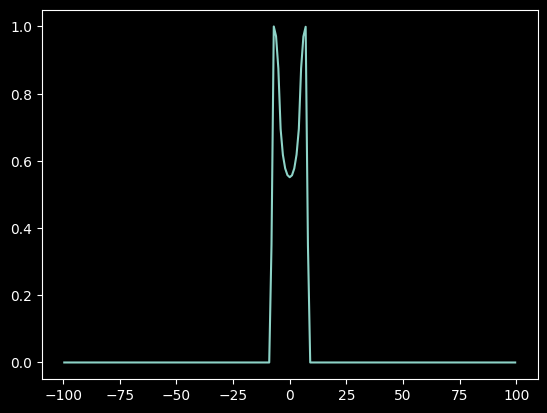

In [6]:
plt.plot(vsbins, hist)

In [10]:
def log_likelihood(theta, vsbins, y, yerr):
    i_rot, i_mag, latitude, log_f = theta
    m = model(vsbins, (i_rot, i_mag, latitude))
    sigma2 = yerr**2 + m**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - m) ** 2 / sigma2 + np.log(sigma2))

In [23]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0, np.pi/2, 52/180* np.pi, 0.1]) + .3 * np.random.randn(4)
soln = minimize(nll, initial, args=(bins, y, yerr))
irot, imag, latitude, log_f = soln.x


print("Maximum likelihood estimates:")
print("irot = {0:.3f}".format((np.pi/2 - irot)/np.pi*180))
print("imag = {0:.3f}".format(imag/np.pi*180))
print("lat = {0:.3f}".format(latitude/np.pi*180))
print("logf = {0:.3f}".format(np.exp(log_f)))

Maximum likelihood estimates:
irot = 81.462
imag = 87.623
lat = 63.133
logf = 1.745


/tmp/ipykernel_508096/2745364780.py:5: RuntimeWarning: invalid value encountered in divide
  return -0.5 * np.sum((y - m) ** 2 / sigma2 + np.log(sigma2))
/tmp/ipykernel_508096/2745364780.py:5: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.sum((y - m) ** 2 / sigma2 + np.log(sigma2))
